<a href="https://colab.research.google.com/github/fovi-llc/trading_evolved/blob/main/Chapter%2012%20-%20Momentum/S%26P_500_Momentum_Model_using_Polygon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Momentum Model for S&P 500 Constituents using Polygon.io Flat Files

This Zipline backtest manages a portfolio selected from the S&P 500 constituents is from the book ***Trading Evolved*** by Andreas F. Clenow (https://www.followingthetrend.com/trading-evolved/).

The US stock data used is from Polygon.io via the `zipline-polygon-bundle` by [Jim White](https://www.linkedin.com/in/jamespaulwhite/) which is available in PyPi here https://pypi.org/project/zipline-reloaded/.

These Google Colab installation preliminaries are by [Jim White](https://www.linkedin.com/in/jamespaulwhite/) and the notebook is in GitHub at [https://github.com/fovi-llc/trading_evolved/Chapter 12 - Momentum/Momentum Model.ipynb](https://github.com/fovi-llc/trading_evolved/blob/main/Chapter%2012%20-%20Momentum/Momentum%20Model.ipynb).  That is code from Clenow's book packaged by Ahmed Aboumalwa at https://github.com/ahmedengu/trading_evolved with updates from https://github.com/RiseT/trading_evolved.

### Install TA-Lib

Colab doesn't have the C/C++ TA-Lib (https://ta-lib.org/) library installed and it isn't in one of the Linux distros it uses either so installing here is annoying.

This is a fast way to get TA-Lib installed including the binary for Colab that will work for zipline-reloaded.

Even though the PyPi `ta-lib-bin` supplies the Python package `talib` it won't satisify `zipline-reloaded` dependency on the PyPi `ta-lib`.  That will result in it trying to install the PyPi `ta-lib` which will fail to build its wheel on Colab.  So the workaround is to install `ta-lib-bin` then make a copy of it with the name `ta-lib` which will satisify the dependency requirement.  If you know of a cleaner way to do this please let me know!

In [18]:
%%bash

TALIBVER=0.4.26
pip install "ta-lib-bin==$TALIBVER" "numpy<2"
distpath=$(pip show ta-lib-bin | grep -oP 'Location: \K.*')
if [[ -n "$distpath" ]]; then
  echo "ta-lib-bin found at $distpath"
  cd "$distpath"
else
  echo "Error: Path to ta-lib-bin not found."
  exit 1
fi
cp -R ta_lib_bin.libs ta_lib.libs
cp -R "ta_lib_bin-$TALIBVER.dist-info" "ta_lib-$TALIBVER.dist-info"
sed -i 's/^Name: ta-lib-bin/Name: ta-lib/' "ta_lib-$TALIBVER.dist-info/METADATA"
diff -u "ta_lib_bin-$TALIBVER.dist-info/METADATA" "ta_lib-$TALIBVER.dist-info/METADATA"
[ $? -eq 1 ] && exit 0
echo "Should have got diff for name in METADATA file"
exit 1

ta-lib-bin found at /usr/local/lib/python3.10/dist-packages
--- ta_lib_bin-0.4.26.dist-info/METADATA	2024-09-30 19:26:01.043149648 +0000
+++ ta_lib-0.4.26.dist-info/METADATA	2024-10-01 00:20:30.672974531 +0000
@@ -1,5 +1,5 @@
 Metadata-Version: 2.1
-Name: ta-lib-bin
+Name: ta-lib
 Version: 0.4.26
 Summary: Python wrapper for TA-Lib
 Home-page: https://github.com/minggnim/ta-lib


### Building TA-Lib binary on Colab.

If the above doesn't work for you, this should but it is more complicated.

Colab doesn't have the C/C++ TA-Lib (https://ta-lib.org/) library installed so we have to build it. This takes a while so I recommend activating Google Drive using the cell below then running this script cell.. Of course if the Linux environment changes then that will need to be deleted and rebuilt.

A shell script to build the TA-Lib C/C++ library based on this https://github.com/TA-Lib/ta-lib-python/issues/590#issuecomment-1534248996.

In [1]:
%%bash

pip show ta-lib
if [ $? -eq 0 ]; then
  echo "ta-lib is already installed"
  exit 0
fi
pwd
if [ -d ta-lib ]; then
  echo "ta-lib directory exists."
else
  wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  tar -xzf ta-lib-0.4.0-src.tar.gz
fi
cd ta-lib
./configure --prefix=/usr
make
make install

Name: ta-lib
Version: 0.4.26
Summary: Python wrapper for TA-Lib
Home-page: https://github.com/minggnim/ta-lib
Author: John Benediktsson
Author-email: mrjbq7@gmail.com
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy
Required-by: 
ta-lib is already installed


An alternative way to run those commands from [https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab](https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab).

### Install Zipline Reloaded

[Quantopian Zipline](https://github.com/quantopian/zipline) is no longer maintained, but **Stefan Jansen** (https://www.ml4trading.io/) author of the comprehensive (and recommended) book ***Machine Learning for Trading*** which also uses Zipline, has "reloaded" it and the dependencies that also became unsupported after the book was published.  Code for Stefan's book is at https://github.com/stefan-jansen/machine-learning-for-trading and the reloaded Python packages (`zipline-reloaded`, `bcolz-zipline`, `pyfolio-reloaded`, `empyrical-reloaded`, and `alphalens-reloaded`) are here: https://github.com/stefan-jansen?tab=repositories.

I use `bcolz-zipline>=1.2.11` and `numpy<2` conditions here to deal with incompatibilty problems that the move to Numpy 2 cause (https://github.com/stefan-jansen/bcolz-zipline/issues/61).  If you're doing this in the future then hopefully the conditions can be omitted.  Also if you can accept the incompatibilties that other of the Colab PyPi packages have with `numpy>2` then go ahead.

In [42]:
!pip install "zipline_polygon_bundle>=0.1.4" "zipline-reloaded>=3.0.4" "bcolz-zipline>=1.2.11" "numpy<2" "pyarrow>=17" pyfolio-reloaded matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 28.3 MB/s eta 0:00:00


### Data Ingestion

To run a Zipline backtest you first need to "ingest" (load) a data bundle.

This notebook uses Polygon.io flat files (*.csv.gz) and API for US Stocks.  That requires a paid subscription for an API key and AWS S3 secrets for the flat files.  More info at https://polygon.io/ and https://polygon.io/knowledge-base/article/how-to-get-started-with-s3.  The subscription needed is "Stocks" and the plan level will determine how many years of data you get access to.

I recommend using Colab secrets for your API key and S3 secrets.  Also, in order to avoid repeatedly downloading and ingesting the data I recommend linking Google Drive and setting the `POLYGON_DATA_DIR` and `ZIPLINE_ROOT` env vars to a folder there.  This script is a working example that uses a folder named "Workspace" in your "My Drive" root.

Of course if you're running this locally then you can just use the command line in the usual fashion.

N.B. Linux shell and build scripts don't like there to be spaces (or other "special") characters in paths so Colab plays tricks to hide the space in "My Drive".

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

if not os.environ.get("WORKSPACE"):
  os.environ["WORKSPACE"] = "/content/drive/MyDrive/Workspace"

%mkdir -p /content/drive/MyDrive/Workspace
%cd /content/drive/MyDrive/Workspace
!pwd

from google.colab import userdata

os.environ["POLYGON_API_KEY"] = userdata.get("POLYGON_API_KEY")
os.environ["POLYGON_S3_Access_ID"] = userdata.get("POLYGON_S3_Access_ID")

os.environ["POLYGON_FILE_ENDPOINT"]="https://files.polygon.io/"

os.environ["POLYGON_DATA_DIR"] = os.path.join(os.environ["WORKSPACE"], "polygon_io")

os.environ["ZIPLINE_ROOT"] = os.path.join(os.environ["WORKSPACE"], "zipline")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Workspace
/content/drive/MyDrive/Workspace


Turns out performance accessing Google Drive from Colab can be very slow.  So we need to copy data from there to the local drive to get decent performance.  We still want to keep the data on Google Drive so we don't have to redownload or reingest it each time.

In [3]:
!mkdir /content/Workspace
!cp -r /content/drive/MyDrive/Workspace/* /content/Workspace

mkdir: cannot create directory ‘/content/Workspace’: File exists
^C


In [4]:
os.environ["WORKSPACE"] = "/content/Workspace"
os.environ["POLYGON_DATA_DIR"] = os.path.join(os.environ["WORKSPACE"], "polygon_io")
os.environ["ZIPLINE_ROOT"] = os.path.join(os.environ["WORKSPACE"], "zipline")

In [14]:
%%bash


# Install rclone
if [ ! `which rclone` ]; then
  echo "Installing rclone"
  curl https://rclone.org/install.sh | sudo bash
else
  echo "rclone is already installed"
fi

# Create an rclone configuration named s3polygon
# Bin the stdout because rclone displays the secret
# and we don't want that in our notebook.
rclone config create s3polygon s3 env_auth=false endpoint=$POLYGON_FILE_ENDPOINT \
  access_key_id=$POLYGON_S3_Access_ID \
  secret_access_key=$POLYGON_API_KEY >/dev/null
# Show the config without the secret
rclone config redacted


rclone is already installed
[s3polygon]
type = s3
env_auth = false
endpoint = https://files.polygon.io/
access_key_id = XXX
secret_access_key = XXX
### Double check the config for sensitive info before posting publicly


Ingest data from Polygon.io into Zipline
Set up your rclone (https://rclone.org/) configuration

Get flat files (*.csv.gz) for US Stock daily aggregates.



In [33]:
%%bash

for year in 2024 2023 2022 2021; do \
    rclone copy s3polygon:flatfiles/us_stocks_sip/day_aggs_v1/$year \
      $POLYGON_DATA_DIR/flatfiles/us_stocks_sip/day_aggs_v1/$year; \
done

2024/09/30 10:14:58 NOTICE: s3: s3 provider "" not known - please set correctly
2024/09/30 10:14:59 NOTICE: 02/2024-02-06.csv.gz: Failed to read metadata: operation error S3: HeadObject, https response error StatusCode: 429, RequestID: , HostID: , api error TooManyRequests: Too Many Requests
2024/09/30 10:14:59 NOTICE: 02/2024-02-07.csv.gz: Failed to read metadata: operation error S3: HeadObject, https response error StatusCode: 429, RequestID: , HostID: , api error TooManyRequests: Too Many Requests
2024/09/30 10:14:59 NOTICE: 02/2024-02-08.csv.gz: Failed to read metadata: operation error S3: HeadObject, https response error StatusCode: 429, RequestID: , HostID: , api error TooManyRequests: Too Many Requests
2024/09/30 10:15:03 NOTICE: s3: s3 provider "" not known - please set correctly
2024/09/30 10:15:03 NOTICE: 07/2023-07-03.csv.gz: Failed to read metadata: operation error S3: HeadObject, https response error StatusCode: 429, RequestID: , HostID: , api error TooManyRequests: Too Ma

Configure the `zipline-polygon-bundle` extension.  A couple different ways to do that and there are a variety of options but this is a simple example.

In [4]:
%%bash

echo $ZIPLINE_ROOT/extension.py

cat >"$ZIPLINE_ROOT"/extension.py <<EOL
from zipline_polygon_bundle import register_polygon_equities_bundle
from exchange_calendars.calendar_helpers import parse_date
from zipline.utils.calendar_utils import get_calendar

calendar = get_calendar("XNYS")

# This start and end dates need to be days when the market was open per the calendar.
# If you don't provide these dates, the bundle will use the first and last dates of the calendar.
# Be sure to set POLYGON_API_KEY and POLYGON_DATA_DIR in your environment before running this.
# See the README.md for info on using rclone to sync data from S3 to your local machine.
register_polygon_equities_bundle(
    "polygon",
    # start_session=parse_date("2024-01-02", calendar=calendar),
    # end_session=parse_date("2024-02-29", calendar=calendar),
    calendar_name=calendar.name,
    agg_time="day"
)
EOL
cat $ZIPLINE_ROOT/extension.py

/content/Workspace/zipline/extension.py
from zipline_polygon_bundle import register_polygon_equities_bundle
from exchange_calendars.calendar_helpers import parse_date
from zipline.utils.calendar_utils import get_calendar

calendar = get_calendar("XNYS")

# This start and end dates need to be days when the market was open per the calendar.
# If you don't provide these dates, the bundle will use the first and last dates of the calendar.
# Be sure to set POLYGON_API_KEY and POLYGON_DATA_DIR in your environment before running this.
# See the README.md for info on using rclone to sync data from S3 to your local machine.
register_polygon_equities_bundle(
    "polygon",
    # start_session=parse_date("2024-01-02", calendar=calendar),
    # end_session=parse_date("2024-02-29", calendar=calendar),
    calendar_name=calendar.name,
    agg_time="day"
)


### List Bundle Ingestions

Before running the Zipline ingest command lets see if you're already done that because every time you run the command it will just add it again, even if you've done it before (because it assumes the data source regularly updates and doesn't know that Quandl is now moribund).

In [6]:
%%bash

export ZIPLINE_ROOT="$ZIPLINE_ROOT"
echo $ZIPLINE_ROOT
zipline bundles

/content/Workspace/zipline
csvdir <no ingestions>
polygon 2024-10-01 01:13:22.524704
polygon 2024-10-01 00:22:34.226359
polygon 2024-09-30 19:52:16.590838
polygon 2024-09-30 19:43:24.147168
polygon 2024-09-30 19:40:04.406005
polygon 2024-09-30 19:33:13.777119
polygon 2024-09-30 10:37:54.785026
polygon 2024-09-30 10:24:18.374774
polygon 2024-09-30 10:18:28.362079
quandl 2024-09-22 22:18:49.991135
quantopian-quandl <no ingestions>


Finally lets ingest the stock data into Zipline.  This will use the Polygon.io flat files (*.csv.gz) and the API to get the split and dividend adjustments.

Unfortunately this took 40 minutes to run on Colab for me.  Don't know what the issue is yet, it runs about 5 times faster on my M2 MacBook Air.

Also annoying is that we're not able to get progress while it runs.  That could be fixed by calling the Python main directly.

In [13]:
!zipline ingest -b polygon --no-show-progress

[2024-10-01T05:35:03+0000-INFO][zipline.data.bundles.core]
 Ingesting polygon
len(paths)=940
paths[0]='/content/Workspace/polygon_io/flatfiles/us_stocks_sip/day_aggs_v1/2021/01/2021-01-04.csv.gz'
paths[-1]='/content/Workspace/polygon_io/flatfiles/us_stocks_sip/day_aggs_v1/2024/09/2024-09-27.csv.gz'
Found existing by_ticker_aggs_arrow_dir='/content/Workspace/polygon_io/flatfiles/us_stocks_sip/day_by_ticker_v1/2021-01-04_2024-09-27.arrow'
Loaded len(splits)=4175 from /content/Workspace/polygon_io/flatfiles/us_stocks_sip/api_cache/2021-01-04_2024-09-27/list_splits.parquet


S&P 500 consituents used here are by Farrell Aultman and downloaded from https://github.com/fja05680/sp500.  The current file name is [`S&P 500 Historical Components & Changes(08-17-2024).csv`](https://github.com/fja05680/sp500/blob/master/S%26P%20500%20Historical%20Components%20%26%20Changes(08-17-2024).csv) but the name will change next time it is updated.  So if the download fails that is probably the reason and you'll need to change `SP500_TICKERS_URL` to the new path.  Note that the URL needs to be to the raw file contents, not the GitHub page.

---



In [5]:
SP500_TICKERS_CSV = os.path.join(os.environ["WORKSPACE"], "sp500_history.csv")

# Get current S&P 500 constituents.  Unfortunately, the URL changes with each update.
# TODO: Switch to `sp500_ticker_start_end.csv` which is more compact and the name is fixed.
# https://github.com/fja05680/sp500
# SP500_TICKERS_URL = "blob:https://github.com/0bb1993a-6157-4f78-9c3e-3723c3ae5229"
SP500_TICKERS_URL = "https://raw.githubusercontent.com/fja05680/sp500/refs/heads/master/S%26P%20500%20Historical%20Components%20%26%20Changes(08-17-2024).csv"

import requests

if not os.path.exists(SP500_TICKERS_CSV):
    response = requests.get(SP500_TICKERS_URL)
    with open(SP500_TICKERS_CSV, 'wb') as f:
        f.write(response.content)
    print(f"Downloaded S&P 500 tickers to {SP500_TICKERS_CSV}")
else:
    print(f"S&P 500 tickers file already exists at {SP500_TICKERS_CSV}")

S&P 500 tickers file already exists at /content/Workspace/sp500_history.csv


In [6]:
%matplotlib inline

import zipline
from zipline.api import order_target_percent, symbol, set_symbol_lookup_date, \
    set_commission, set_slippage, schedule_function, \
    date_rules, time_rules, get_datetime
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import pyfolio as pf
import pandas as pd
import numpy as np
from scipy import stats
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage

from zipline.errors import SymbolNotFound

"""
Model Settings
"""
intial_portfolio = 10000000
momentum_window = 125
minimum_momentum = 40
portfolio_size = 30
vola_window = 20

"""
Commission and Slippage Settings
"""
enable_commission = True
commission_pct = 0.001
enable_slippage = True
slippage_volume_limit = 0.25
slippage_impact = 0.1

"""
Helper functions.
"""

def momentum_score(ts):
    """
    Input:  Price time series.
    Output: Annualized exponential regression slope,
            multiplied by the R2
    """
    # Make a list of consecutive numbers
    x = np.arange(len(ts))
    # Get logs
    log_ts = np.log(ts)
    # Calculate regression values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts)
    # Annualize percent
    annualized_slope = (np.power(np.exp(slope), 252) - 1) * 100
    #Adjust for fitness
    score = annualized_slope * (r_value ** 2)
    return score

def volatility(ts):
    return ts.pct_change().rolling(vola_window).std().iloc[-1]

def output_progress(context):
    """
    Output some performance numbers during backtest run
    This code just prints out the past month's performance
    so that we have something to look at while the backtest runs.
    """

    # Get today's date
    today = get_datetime().date()

    # Calculate percent difference since last month
    perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1

    # Print performance, format as percent with two decimals.
    print("{} - Last Month Result: {:.2%}".format(today, perf_pct))

    # Remember today's portfolio value for next month's calculation
    context.last_month = context.portfolio.portfolio_value

"""
Initialization and trading logic
"""
def initialize(context):

    # Set commission and slippage.
    if enable_commission:
        comm_model = PerDollar(cost=commission_pct)
    else:
        comm_model = PerDollar(cost=0.0)
    set_commission(comm_model)

    if enable_slippage:
        slippage_model=VolumeShareSlippage(volume_limit=slippage_volume_limit, price_impact=slippage_impact)
    else:
        slippage_model=FixedSlippage(spread=0.0)
    set_slippage(slippage_model)

    # Used only for progress output.
    context.last_month = intial_portfolio

    # Fetch and store index membership
    context.index_members = pd.read_csv(SP500_TICKERS_CSV, index_col=0, parse_dates=[0])

    #Schedule rebalance monthly.
    schedule_function(
        func=rebalance,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open()
    )

def rebalance(context, data):
    # Write some progress output during the backtest
    output_progress(context)

    # Ok, let's find which stocks can be traded today.

    # First, get today's date
    today = pd.to_datetime(get_datetime().date())
    # print(f"{get_datetime()=}")

    # # Second, get the index makeup for all days prior to today.
    all_prior = context.index_members.loc[context.index_members.index < (today + pd.Timedelta(days=1))]

    # # Now let's snag the first column of the last, i.e. latest, entry.
    latest_day = all_prior.iloc[-1,0]

    # # Split the text string with tickers into a list
    list_of_tickers = latest_day.split(',')

    # Finally, get the Zipline symbols for the tickers
    # todays_universe = [symbol(ticker) for ticker in list_of_tickers]

    # A way to do that but able to work even if a ticker is not found in the data bundle.
    todays_universe = []

    # Can't set the symbol lookup to be today because zipline.api.set_symbol_lookup_date
    # always localizes to UTC.  That then fails in assets._lookup_symbol_strict
    # which does a comparison between session start and end (tz naive as required
    # by exchange_calendars parse_date) and symbol_lookup_date which is UTC.
    # If we don't set the lookup date it uses the end of session
    # from sim_params which defeats the whole purpose of time sensitivity for
    # symbol mapping because delisted (or reassigned) tickers fail.
    # Like for instance CTL which changed symbol to LUMN September 2020.
    # set_symbol_lookup_date(get_datetime())

    for ticker in list_of_tickers:
        try:
            todays_universe.append(symbol(ticker))
        except SymbolNotFound:
            print(f"SymbolNotFound: {ticker} {get_datetime()=}")


    # There's your daily universe. But we could of course have done this in one go.
    """

    # This line below does the same thing,
    # using the same logic to fetch today's stocks.

    todays_universe = [
        symbol(ticker) for ticker in
        context.index_members.loc[context.index_members.index < today].iloc[-1,0].split(',')
    ]
    """

    # Get historical data
    hist = data.history(todays_universe, "close", momentum_window, "1d")

    # Make momentum ranking table
    ranking_table = hist.apply(momentum_score).sort_values(ascending=False)

    """
    Sell Logic

    First we check if any existing position should be sold.
    * Sell if stock is no longer part of index.
    * Sell if stock has too low momentum value.
    """
    kept_positions = list(context.portfolio.positions.keys())
    for security in context.portfolio.positions:
        if (security not in todays_universe):
            order_target_percent(security, 0.0)
            kept_positions.remove(security)
        elif ranking_table[security] < minimum_momentum:
            order_target_percent(security, 0.0)
            kept_positions.remove(security)


    """
    Stock Selection Logic

    Check how many stocks we are keeping from last month.
    Fill from top of ranking list, until we reach the
    desired total number of portfolio holdings.
    """
    replacement_stocks = portfolio_size - len(kept_positions)
    buy_list = ranking_table.loc[
        ~ranking_table.index.isin(kept_positions)][:replacement_stocks]

    new_portfolio = pd.concat(
        (buy_list,
         ranking_table.loc[ranking_table.index.isin(kept_positions)])
    )


    """
    Calculate inverse volatility for stocks,
    and make target position weights.
    """
    vola_table = hist[new_portfolio.index].apply(volatility)
    inv_vola_table = 1 / vola_table
    sum_inv_vola = np.sum(inv_vola_table)
    vola_target_weights = inv_vola_table / sum_inv_vola

    for security, rank in new_portfolio.items():
        weight = vola_target_weights[security]
        if security in kept_positions:
            order_target_percent(security, weight)
        else:
            if ranking_table[security] > minimum_momentum:
                order_target_percent(security, weight)

def analyze(context, perf):

    perf['max'] = perf.portfolio_value.cummax()
    perf['dd'] = (perf.portfolio_value / perf['max']) - 1
    maxdd = perf['dd'].min()

    ann_ret = (np.power((perf.portfolio_value.iloc[-1] / perf.portfolio_value.iloc[0]),(252 / len(perf)))) - 1

    print("Annualized Return: {:.2%} Max Drawdown: {:.2%}".format(ann_ret, maxdd))

    return

# Can't use tz because exchange_calendars says so:
# /usr/local/lib/python3.10/dist-packages/exchange_calendars/calendar_helpers.py in parse_date(date, param_name, calendar, raise_oob)
#     377     if ts.tz is not None:
#     378         raise ValueError(
# --> 379             f"Parameter `{param_name}` received with timezone defined as '{ts.tz.key}'"
#     380             f" although a Date must be timezone naive."
#     381         )

# start = datetime(1997, 1, 1, 8, 15, 12, 0, pytz.UTC)
# start = datetime(2016, 1, 1, 8, 15, 12, 0, pytz.UTC)
# end = datetime(2018, 12, 31, 8, 15, 12, 0, pytz.UTC)

# start = datetime(2016, 8, 1, 0, 0, 0)
# end = datetime(2024, 7, 31, 0, 0, 0)

start = datetime(2020, 8, 3, 0, 0, 0)
end = datetime(2024, 8, 30, 0, 0, 0)

perf = zipline.run_algorithm(
    start=pd.to_datetime(start), end=pd.to_datetime(end),
    initialize=initialize,
    analyze=analyze,
    capital_base=intial_portfolio,
    data_frequency = 'daily',
    bundle='polygon')

2020-08-03 - Last Month Result: 0.00%
SymbolNotFound: CTL get_datetime()=Timestamp('2020-08-03 20:00:00+0000', tz='UTC')
SymbolNotFound: ETFC get_datetime()=Timestamp('2020-08-03 20:00:00+0000', tz='UTC')
SymbolNotFound: MYL get_datetime()=Timestamp('2020-08-03 20:00:00+0000', tz='UTC')
SymbolNotFound: NBL get_datetime()=Timestamp('2020-08-03 20:00:00+0000', tz='UTC')


/usr/local/lib/python3.10/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.10/dist-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in divide
  np.divide(


2020-09-01 - Last Month Result: 0.00%
SymbolNotFound: CTL get_datetime()=Timestamp('2020-09-01 20:00:00+0000', tz='UTC')
SymbolNotFound: ETFC get_datetime()=Timestamp('2020-09-01 20:00:00+0000', tz='UTC')
SymbolNotFound: MYL get_datetime()=Timestamp('2020-09-01 20:00:00+0000', tz='UTC')
SymbolNotFound: NBL get_datetime()=Timestamp('2020-09-01 20:00:00+0000', tz='UTC')


/usr/local/lib/python3.10/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.10/dist-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in divide
  np.divide(


2020-10-01 - Last Month Result: 0.00%
SymbolNotFound: ETFC get_datetime()=Timestamp('2020-10-01 20:00:00+0000', tz='UTC')
SymbolNotFound: MYL get_datetime()=Timestamp('2020-10-01 20:00:00+0000', tz='UTC')
SymbolNotFound: NBL get_datetime()=Timestamp('2020-10-01 20:00:00+0000', tz='UTC')


/usr/local/lib/python3.10/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.10/dist-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in divide
  np.divide(


2020-11-02 - Last Month Result: 0.00%
SymbolNotFound: MYL get_datetime()=Timestamp('2020-11-02 21:00:00+0000', tz='UTC')


/usr/local/lib/python3.10/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.10/dist-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in divide
  np.divide(


2020-12-01 - Last Month Result: 0.00%


/usr/local/lib/python3.10/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.10/dist-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in divide
  np.divide(


2021-01-04 - Last Month Result: 0.00%


/usr/local/lib/python3.10/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.10/dist-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in divide
  np.divide(


2021-02-01 - Last Month Result: 0.00%


/usr/local/lib/python3.10/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.10/dist-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in divide
  np.divide(


2021-03-01 - Last Month Result: 0.00%


/usr/local/lib/python3.10/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.10/dist-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in divide
  np.divide(


2021-04-01 - Last Month Result: -1.57%
2021-05-03 - Last Month Result: 1.97%
2021-06-01 - Last Month Result: 3.99%
2021-07-01 - Last Month Result: -1.23%
2021-08-02 - Last Month Result: -4.27%
2021-09-01 - Last Month Result: 4.80%
2021-10-01 - Last Month Result: -7.15%
2021-11-01 - Last Month Result: 7.48%
2021-12-01 - Last Month Result: -3.53%
2022-01-03 - Last Month Result: 0.30%
2022-02-01 - Last Month Result: -6.76%
2022-03-01 - Last Month Result: 0.62%
2022-04-01 - Last Month Result: 5.72%
2022-05-02 - Last Month Result: -3.12%
2022-06-01 - Last Month Result: 5.20%
2022-07-01 - Last Month Result: -10.17%
2022-08-01 - Last Month Result: -0.24%
2022-09-01 - Last Month Result: -0.06%
2022-10-03 - Last Month Result: -0.94%
2022-11-01 - Last Month Result: 0.45%
2022-12-01 - Last Month Result: 4.01%
2023-01-03 - Last Month Result: -5.89%
2023-02-01 - Last Month Result: 4.59%
2023-03-01 - Last Month Result: -2.29%
2023-04-03 - Last Month Result: 0.23%
2023-05-01 - Last Month Result: -0.5

In [7]:
data = perf['portfolio_value'].copy()
data.index = data.index.date

data.to_csv('systematic_momentum.csv')

/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.409%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2020-08-03
End date,2024-08-30
Total months,48
,Backtest
Annual return,1.409%
Cumulative returns,5.866%
Annual volatility,16.203%
Sharpe ratio,0.17
Calmar ratio,0.07
Stability,0.02
Max drawdown,-20.173%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,20.17,2021-06-08,2023-03-15,2024-03-20,727
1,13.24,2024-06-18,2024-08-05,NaT,NaN
2,9.87,2021-03-15,2021-04-20,2021-06-02,58
3,7.00,2024-04-01,2024-04-19,2024-06-12,53
4,1.04,2024-06-13,2024-06-14,2024-06-17,3


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

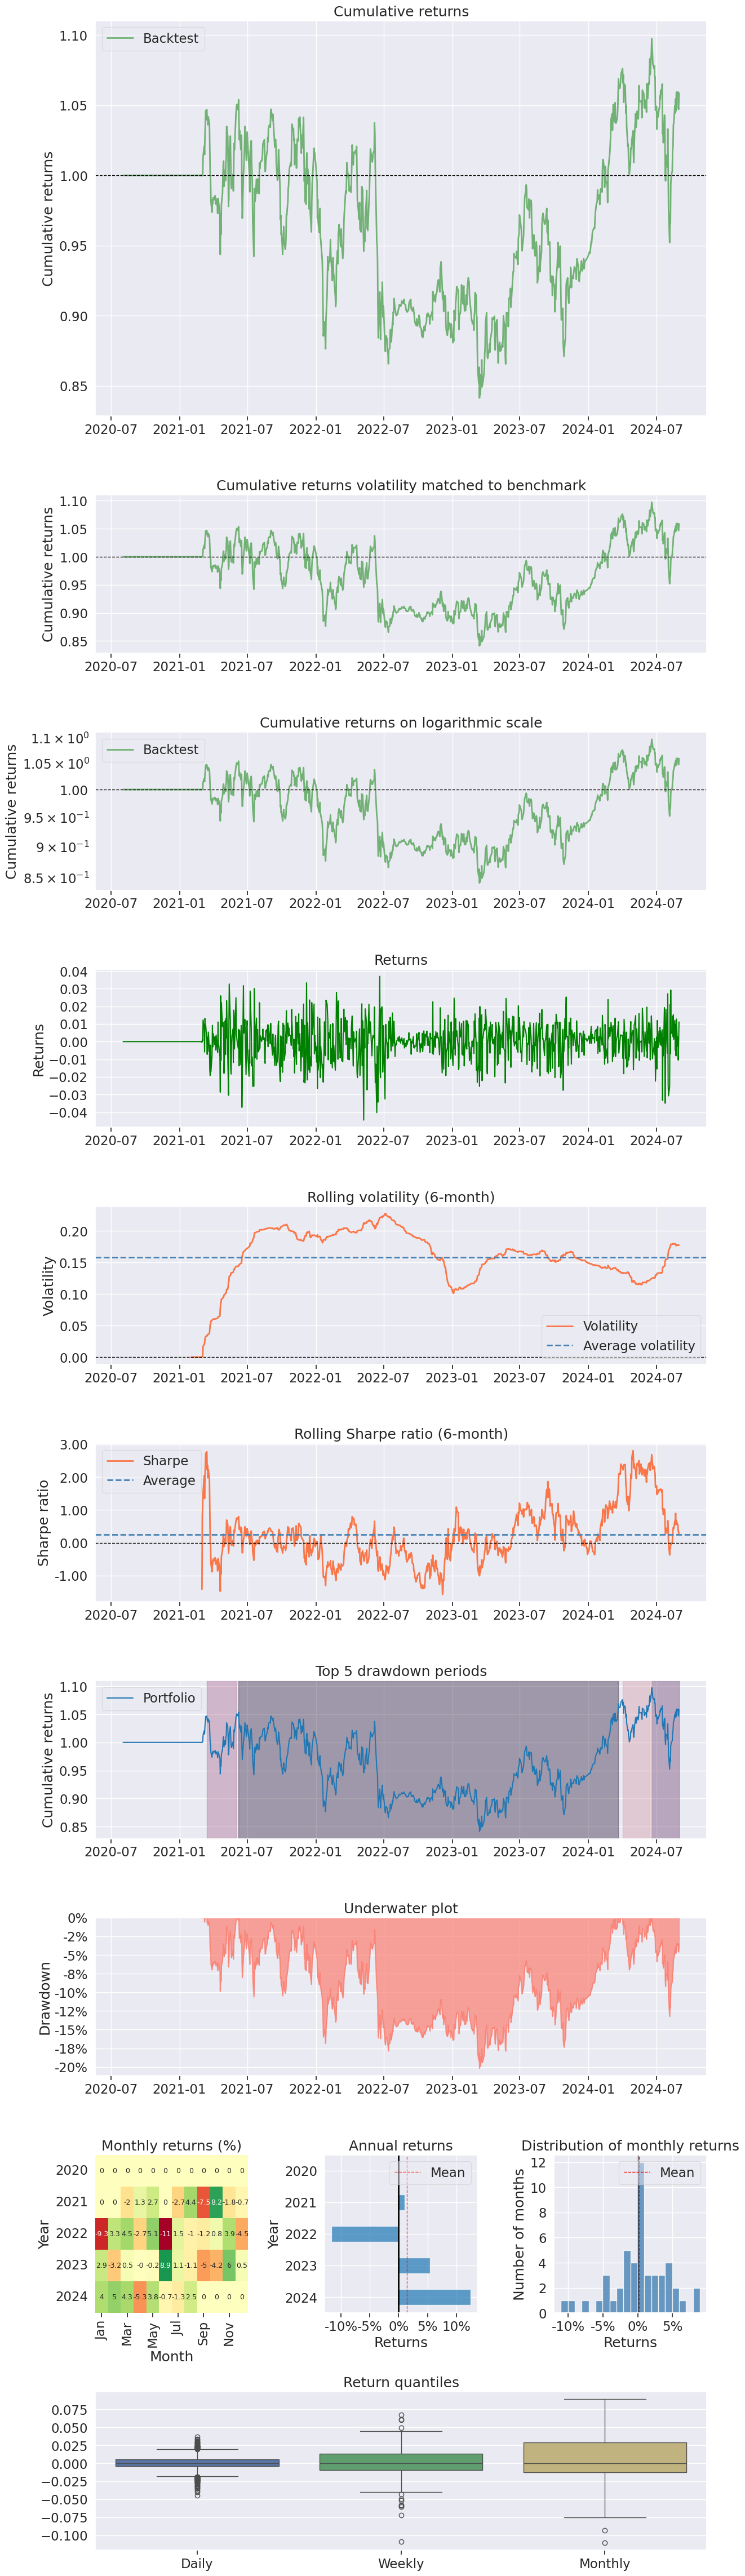

In [10]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
pf.create_returns_tear_sheet(returns, benchmark_rets=None)

In [8]:
perf.portfolio_value.to_csv('125d version.csv')